# <span style="color:green"> Laboratorio di simulazione numerica </span>
### Martina Colombo, 977556
## <span style="color:blue">  Esercitazione 5</span>

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from matplotlib.ticker import FormatStrFormatter
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

In [4]:
params = {'font.size':18, 'legend.fontsize': 'large' ,'axes.labelsize': 'x-large','axes.titlesize':'x-large','xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
plt.rcParams.update(params)

### Esercizio 05.1

L'obiettivo di questa esercitazione è quello di utilizzare l'algoritmo di Metropolis per calcolare il valore medio e l'incertezza del raggio di un atomo di idrogeno per lo stato fondamentale e per lo stato 2p. L'algoritmo di Metropolis genera una catena di Markov di elementi $x_n$, il passaggio da uno stato $x_i$ ad uno stato $x_j$ per una catena di Markov è determinato dalla matrice di trasferimento $K(x_j|x_i)$. Se esiste un numero $m>0$ tale per cui $(K^m)_{ij}>0$ per tutti gli stati $i, j$ del sistema la matrice $K$ si dice regolare. Il teorema di Markov afferma che se una matrice è regolare ammette un’unica distribuzione invariante $p(x)$ e per qualsiasi distribuzione iniziale $d(x)$ è possibile ottenere la distribuzione $p(x)$ applicando a $d(x)$ un numero $n\to \infty$ di volte la matrice di trasferimento $K$. Questo significa che se si riesce a trovare una matrice di trasferimento regolare $K$ che ha come distribuzione invariante la distribuzione $p(x)$ nota, la distribuzione di probabilità $d_n(x)$ dei punti $x_n$ generati tramite la matrice $K$ tende asintoticamente alla distribuzione $p(x)$. Questo metodo rappresenta un modo per campionare una distribuzione target $p(x)$ utilizzando una catena di Markov. L'idea dell'algoritmo è quella di trovare una matrice di trasferimento $K(x|y)$ che sia regolare e che abbia $p(x)$ come distribuzione invariante. La matrice di trasferimento ottimale si ricava decomponendo $K$ in due contributi: una matrice di transizione $T(x|y)$ e una probabilità di accettazione $A(x|y)$. In particolare si dimostra che scegliendo come probabilità di accettazione $A(x|y)=min[1, \frac{p(x)}{p(y)}]$ con $T(x|y)=T(y|x)$ viene soddisfatta l'ipotesi che $p(x)$ sia invariante per $K$. 

**Funzionamento dell'algoritmo:**

Per prima cosa si sceglie un buon punto di partenza $x_n$ e la forma di $T(x_{n+1}|x_n)$, fatto questo l'algoritmo genera una nuova configurazione $x_{n+1}$ tramite la matrice di transizione $T$, valuta la probabilità di accettazione $A(x_{n+1}|x_n)=min[1, \frac{p(x_{n+1})}{p(x_n)}]$ e la confronta con un numero casuale uniformemente distribuito tra $0$ e $1$, se il numero casuale è minore o uguale della probabilità di accettazione allora la mossa viene accettata e il sistema si sposta nella nuova configurazione $x_{n+1}$, altrimenti la mossa viene rifiutata e il sistema rimane in $x_n$, si ripete questo procedimento per un numero sufficientemente grande di volte. In questo modo viene generato un random walk $x_n$ dove la distribuzione di probabilità degli $x_n$ tende per $n$ grandi alla $p(x)$ che conosciamo, l'efficienza dell'algoritmo dipenderà dalla scelta della matrice di transizione $T$ e dalla probabilità di accettazione $A$. In particolare per avere una buona efficienza è consigliabile settare i parametri del sistema in modo tale che il rate di accettazione $A(x|y)$ sia intorno al $50\%$.

Le forme analitiche delle funzioni d'onda per lo stato fondamentale e lo stato 2p dell'atomo di idrogeno in coordinate sferiche sono rispettivamente: 

$$ \begin{align*}\Psi_{1,0,0}(r,\theta,\phi)&=
\frac{a_0^{-3/2}}{\sqrt{\pi}} e^{-r/a_0} \\ \Psi_{2,1,0}(r,\theta,\phi)&=
\frac{a_0^{-5/2}}{8}\sqrt{\frac{2}{\pi}} r e^{-r/2a_0} \cos(\theta). \end{align*}$$ 

Dalla teoria conosciamo anche i valori medi teorici dei raggi per lo stato fondamentale e per lo stato 2p:

$$
\left\langle r \right\rangle_{\Psi_{1,0,0}} = \frac{3}{2}a_0
\quad
\left\langle r \right\rangle_{\Psi_{2,1,0}} = 5 a_0
$$ 

dove $a_0$ rappresenta il raggio di Bohr $a_0\simeq 0.052917$.

Per applicare l'algoritmo di Metropolis è necessario per prima cosa conoscere la densità di probabilità $p(x)$ che vogliamo calcolare, a questo proposito sapendo che il modulo quadro della funzione d'onda rappresenta la densità di probabilità che l'elettrone ha di trovarsi ad una certa distanza $r$ dal nucleo ad un certo tempo $t$, ricaviamo i moduli quadri delle funzioni d'onda per entrambi gli stati in coordinate cartesiane: 

$$\begin{align*}|\Psi_{1,0,0}(x,y,z)|^2&=\frac{a_0^{-5}}{\pi} e^{-2\sqrt{x^2+y^2+z^2}/a_0} \\ |\Psi_{2,1,0}(x,y,z)|^2&=\frac{a_0^{-5}}{32\pi} z^2 e^{-2\sqrt{x^2+y^2+z^2}/a_0} \end{align*}$$



Scegliamo poi un punto $(x_0, y_0, z_0)$ intelligente da cui far partire l'algoritmo così che abbia una convergenza rapida, una possibile scelta può essere quella di partire da punti vicini al raggio di Bohr visto che la densità di probabilità è centrata intorno a questo valore, scegliamo dunque il punto di partenza $(x_0=0.05, y_0=0.05, z_0=0.05)$. Utilizziamo come **probabilità di transizione** $T(\vec x|\vec y)$ la distribuzione **uniforme** con valori uniformemente distribuiti tra $\vec x + \delta$ e $ \vec x - \delta$ dove $\vec x = (x,y,z)$, scegliamo $\delta$ in modo tale che la probabilità di accettazione sia del $50\%$. Se dovessimo scegliere un punto molto lontano dall'origine si ha che l'algoritmo non converge in tempi ragionevoli alla soluzione corretta, di conseguenza l'algoritmo non è efficiente. Per quanto riguarda il metodo a blocchi scegliamo un valore del numero di step totali pari a $M=10^6$ e un numero di blocchi pari a $N=10^2$, dai grafici successivi vediamo che questa scelta è sufficiente per ottenere delle medie di blocco sensate e delle incertezze che diminuiscono all'aumetare del numero di blocchi, possiamo dire dunque che la larghezza dei blocchi $L=M/N=10^4$ sia tale da avere delle grandezze scorrelate, per un analisi più approfondita bisognerebbe prendere in considerazione la funzione di autocorrelazione (che introdurremo nell'esercitazione 7) tramite cui potremmo determinare in modo sicuramente più accurato il numero di passi in cui decadono le correlazioni. 


Per testare ulteriormente l'algoritmo di Metropolis decidiamo di utilizzare una **probabilità di transizione** $T(\vec x|\vec y)$ **di tipo Gaussiano**. Anche in questo caso decidiamo di partire da un punto vicino a quello del raggio di Bohr per tutte e tre le coordinate, l'algoritmo genera tramite la matrice di transizione tre nuove coordiante campionate da una distribuzione gaussiana con media pari al punto in cui mi trovo e varianza pari a $\delta$, calcola la probabilità di accettazione, genera un numero casuale tra $0$ e $1$ con cui viene confrontata la probabilità di accettazione e decide se accettare o meno la mossa. Anche in questo caso bisogna scegliere il valore di $\delta$ in modo tale che l'accettazione sia pari al $50\%$. 

- Riportiamo di seguito i grafici del valor medio del raggio e della relativa incertezza in funzione del numero di blocchi $\#_{blocks}$, nel medesimo grafico riportiamo sia il caso in cui abbiamo utilizzato una probabilità di transizione uniforme sia una probabilità di transizione di tipo gaussiano, confrontiamo i risultati con il valore atteso.

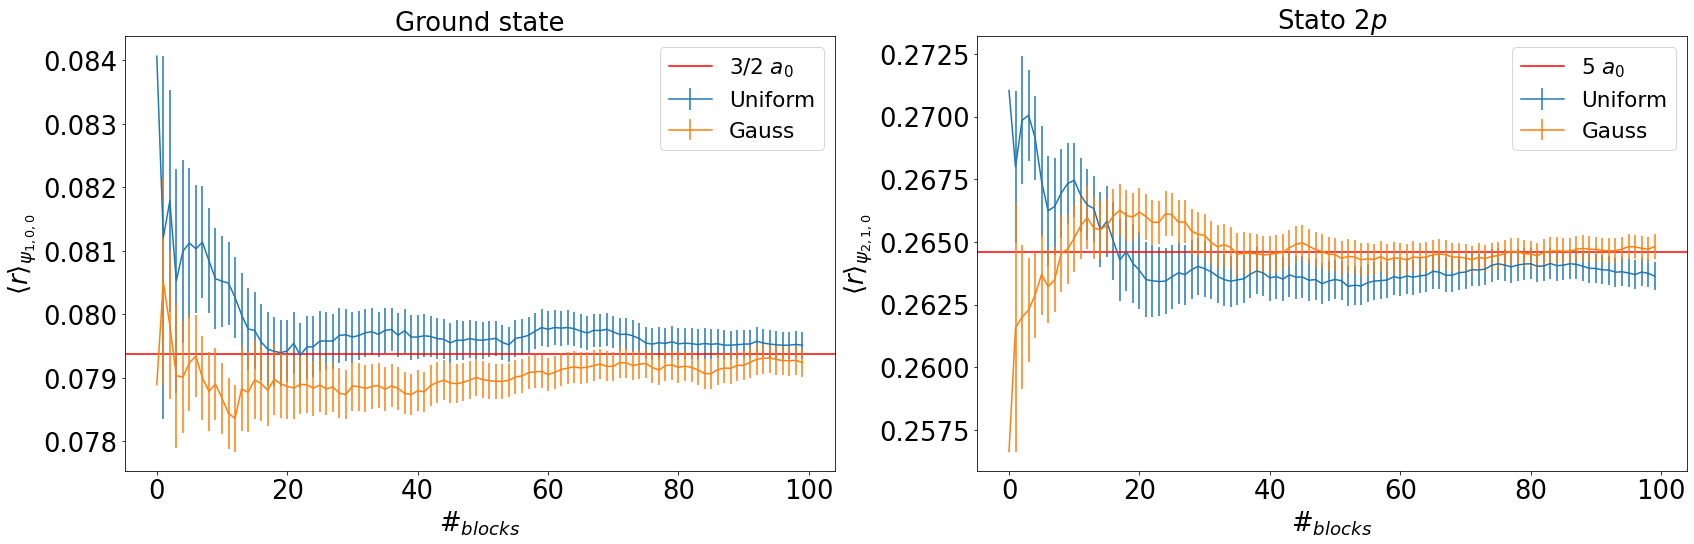

In [5]:
plt.figure(figsize=(28,8))

plt.subplot(1,2,1)


x, r_gs, err_gs= np.loadtxt("r_gs.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
plt.errorbar(x,r_gs,yerr=err_gs, label='Uniform')
plt.ylabel('$\langle{r}\\rangle_{\psi_{1,0,0}}$')
plt.xlabel('$\#_{blocks}$')
plt.axhline(y=(3/2)*0.0529177210903 , color='red', label='3/2 $a_0$')

x, r_gs, err_gs= np.loadtxt("r_gs_Gauss.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
plt.errorbar(x,r_gs,yerr=err_gs, label='Gauss')
plt.ylabel('$\langle{r}\\rangle_{\psi_{1,0,0}}$')
plt.xlabel('$\#_{blocks}$')
plt.title('Ground state')
plt.legend()

plt.subplot(1,2,2)

x, r_2p, err_2p= np.loadtxt("r_2p.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
plt.errorbar(x,r_2p,yerr=err_2p, label='Uniform')
plt.ylabel('$\langle{r}\\rangle_{\psi_{2,1,0}}$')
plt.xlabel('$\#_{blocks}$')
plt.axhline(y=5*0.0529177210903, color='red', label='5 $a_0$')

x, r_2p, err_2p= np.loadtxt("r_2p_Gauss.dat", usecols=(0,1,2), delimiter=' ', unpack='true')
plt.errorbar(x,r_2p,yerr=err_2p, label='Gauss')
plt.ylabel('$\langle{r}\\rangle_{\psi_{2,1,0}}$')
plt.xlabel('$\#_{blocks}$')
plt.title('Stato $2p$')
plt.legend()



plt.show()

Notiamo che in entrambi i casi otteniamo una buona convergenza al valore atteso. Entrambe le scelte delle probabilità di transizione risultano quindi essere efficaci nel campionamento delle densità di probabilità.

- Utilizziamo ora le configurazioni create dall'algoritmo durante il processo di sampling viste come densità di probabilità per fare un grafico 3D che ci mostra la forma degli orbitali elettrici per i due stati. Nello stato fondamentale ci aspettiamo un orbitale sferico, mentre nello stato $2p$  ci aspettiamo di vedere un doppio lobo centrato nel nucleo dell'atomo. Come si può vedere nelle figure di seguito sia nel caso di probabilità di transizione uniforme che nel caso di probabilità gaussiana si ottengono le forme tridimensionali tipiche dei due stati. 

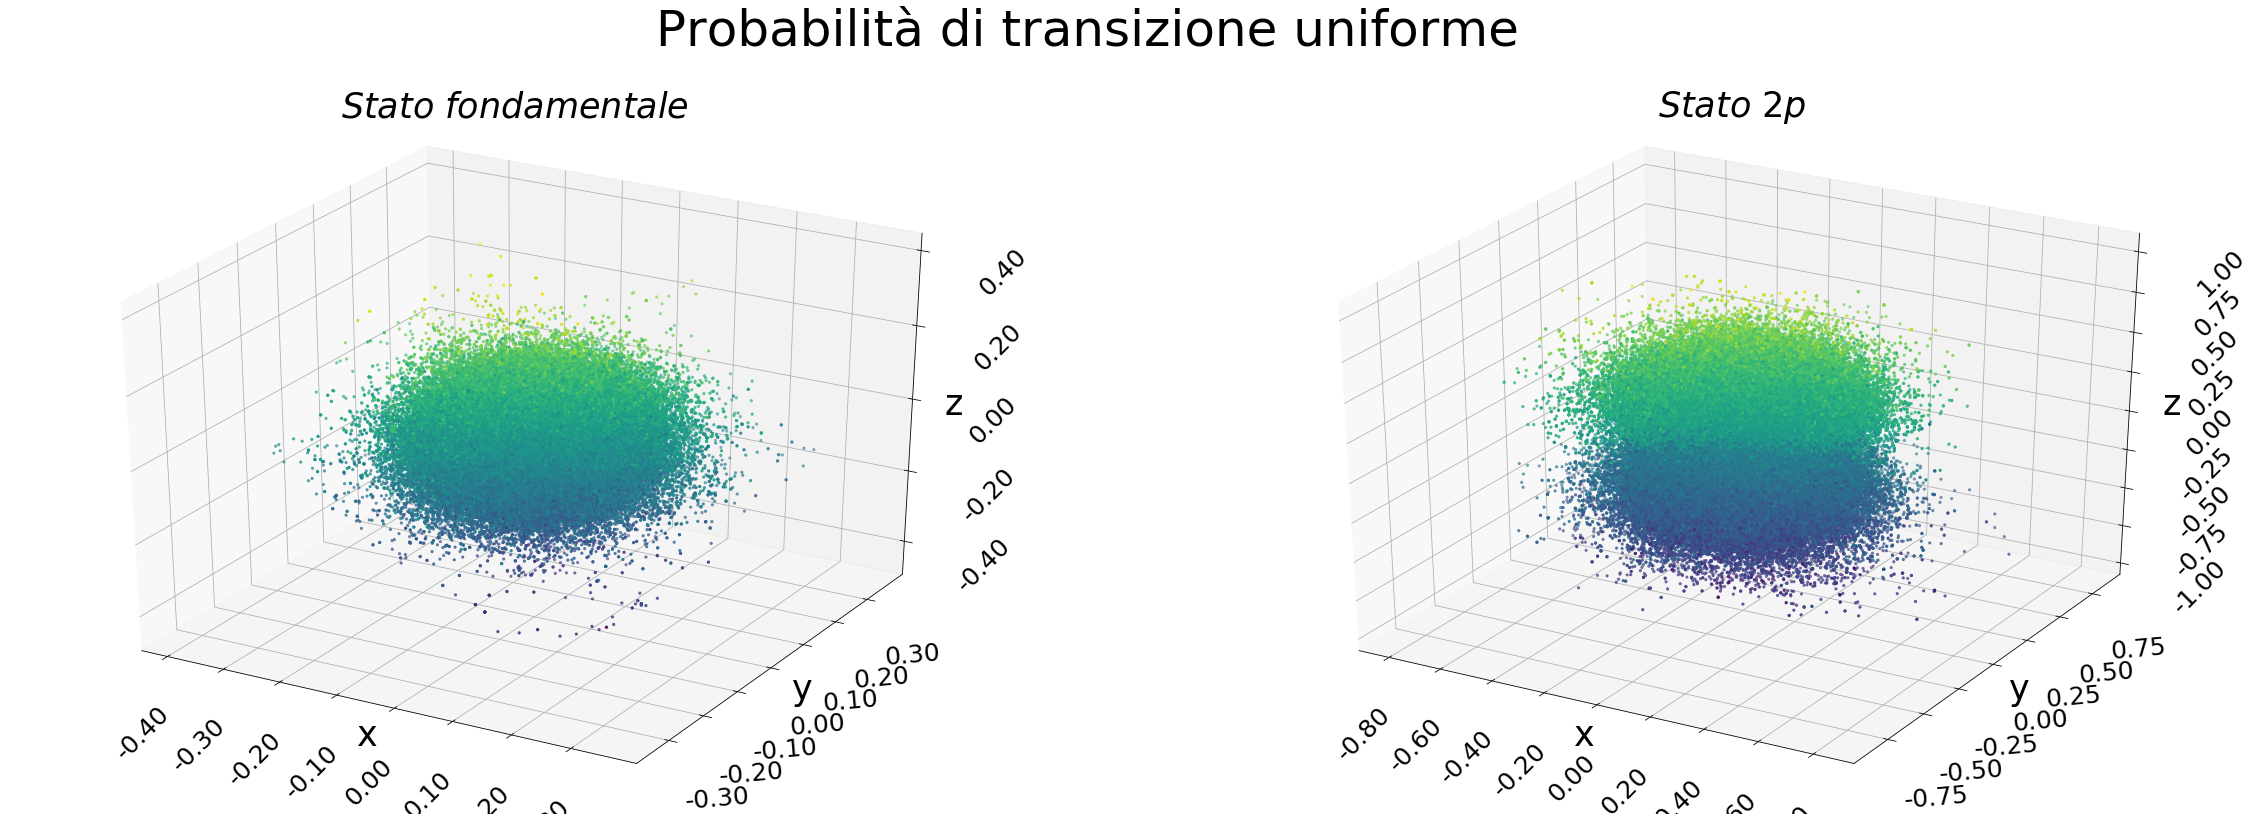

In [27]:
plt.figure(figsize=[40, 13])
plt.suptitle('Probabilità di transizione uniforme', fontsize='50')

ax = plt.subplot(1,2,1, projection='3d')
x, y, z= np.loadtxt("Config_gs.dat", usecols=(0,1,2), delimiter=' ', unpack='true')

ax.scatter3D(x, y, z, c=z, zdir='z', marker='.')

ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.set_yticklabels(ax.get_yticks(), rotation = 5)
ax.set_zticklabels(ax.get_zticks(), rotation = 45)
ax.tick_params(axis='x', which='major', pad=30)
ax.tick_params(axis='y', which='major', pad=35)
ax.tick_params(axis='z', which='major', pad=40)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.zaxis.set_tick_params(labelsize=25)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('x', fontsize=35)
ax.set_ylabel('y', fontsize=35)
ax.set_zlabel('z', fontsize=35)

ax.set_title('$Stato$ $fondamentale$', fontsize=35, pad=40)


ax = plt.subplot(1,2,2, projection='3d')
x, y, z= np.loadtxt("Config_2p.dat", usecols=(0,1,2), delimiter=' ', unpack='true')

ax.scatter3D(x, y, z, c=z, zdir='z', marker='.')

ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.set_yticklabels(ax.get_yticks(), rotation = 5)
ax.set_zticklabels(ax.get_zticks(), rotation = 45)
ax.tick_params(axis='x', which='major', pad=30)
ax.tick_params(axis='y', which='major', pad=35)
ax.tick_params(axis='z', which='major', pad=40)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.zaxis.set_tick_params(labelsize=25)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('x', fontsize=35)
ax.set_ylabel('y', fontsize=35)
ax.set_zlabel('z', fontsize=35)

ax.set_title('$Stato$ $2p$', fontsize=35, pad=40)


plt.show()

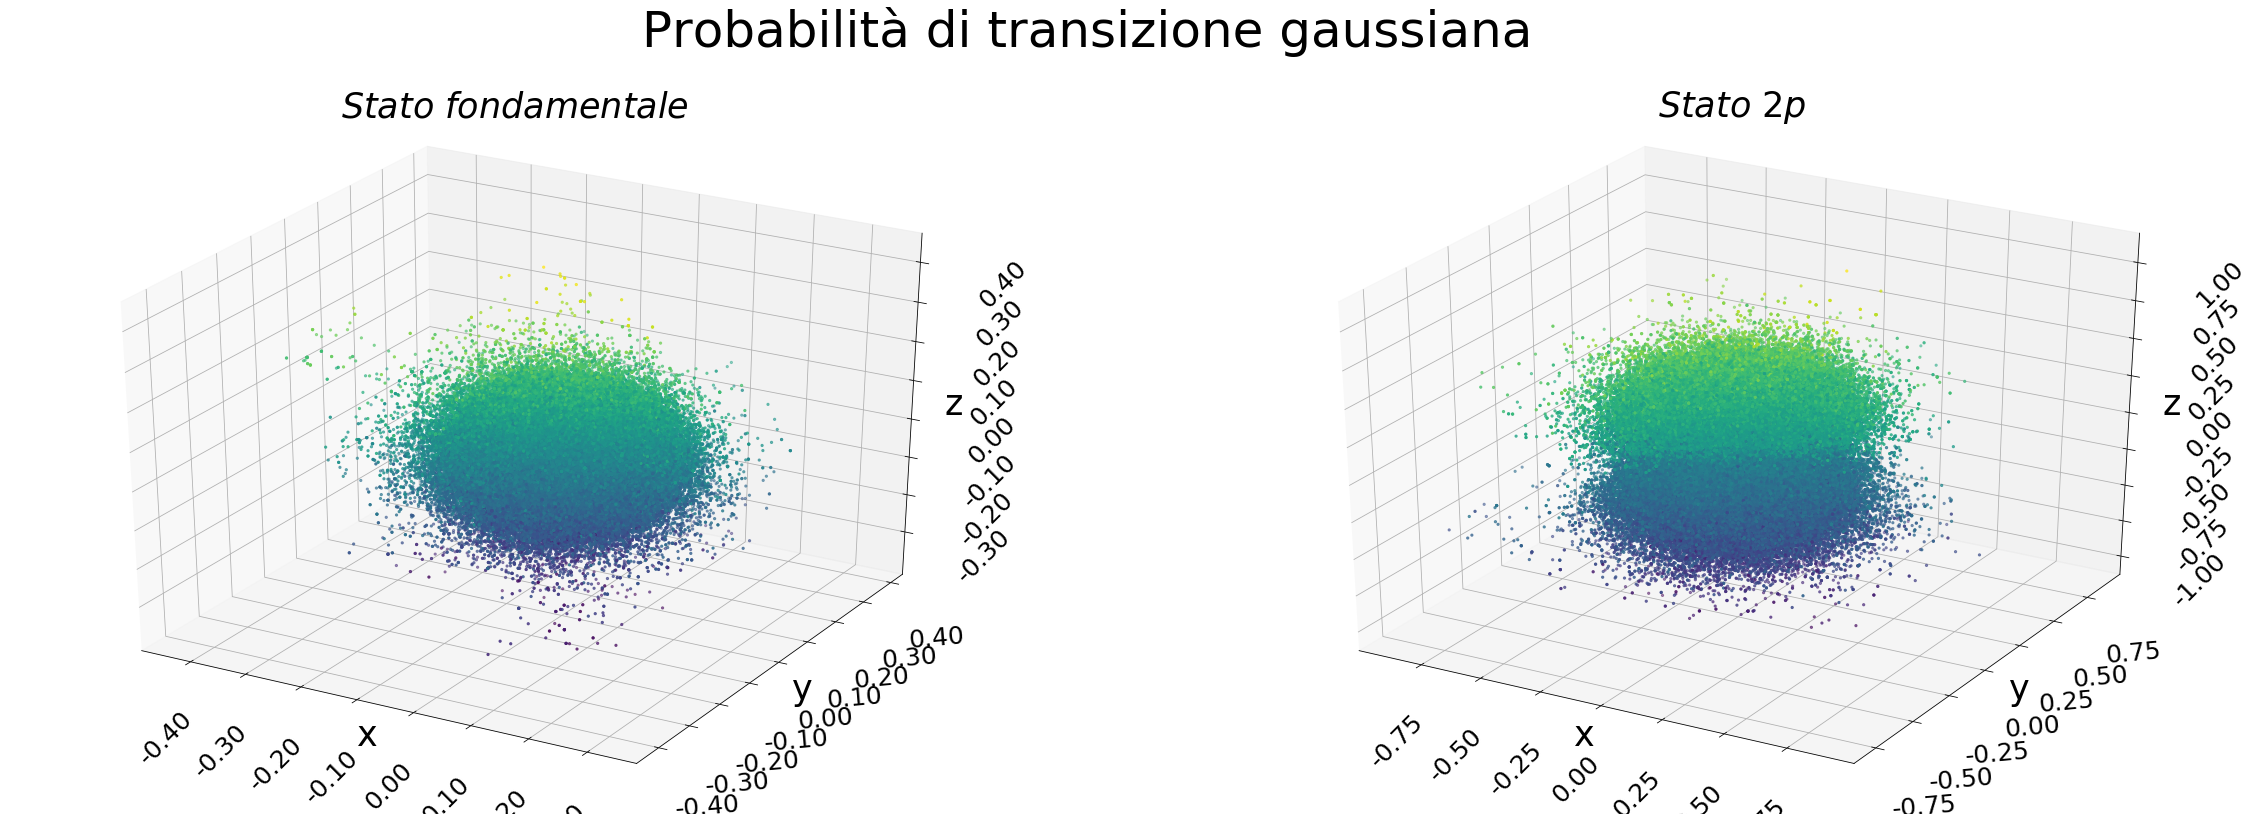

In [26]:
plt.figure(figsize=[40, 13])
plt.suptitle('Probabilità di transizione gaussiana', fontsize='50')

ax = plt.subplot(1,2,1, projection='3d')
x, y, z= np.loadtxt("Config_gs_gauss.dat", usecols=(0,1,2), delimiter=' ', unpack='true')

ax.scatter3D(x, y, z, c=z, zdir='z', marker='.')

ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.set_yticklabels(ax.get_yticks(), rotation = 5)
ax.set_zticklabels(ax.get_zticks(), rotation = 45)
ax.tick_params(axis='x', which='major', pad=30)
ax.tick_params(axis='y', which='major', pad=35)
ax.tick_params(axis='z', which='major', pad=40)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.zaxis.set_tick_params(labelsize=25)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('x', fontsize=35)
ax.set_ylabel('y', fontsize=35)
ax.set_zlabel('z', fontsize=35)

ax.set_title('$Stato$ $fondamentale$', fontsize=35, pad=40)

ax = plt.subplot(1,2,2, projection='3d')
x, y, z= np.loadtxt("Config_2p_gauss.dat", usecols=(0,1,2), delimiter=' ', unpack='true')

ax.scatter3D(x, y, z, c=z, zdir='z',  marker='.')

ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.set_yticklabels(ax.get_yticks(), rotation = 5)
ax.set_zticklabels(ax.get_zticks(), rotation = 45)
ax.tick_params(axis='x', which='major', pad=30)
ax.tick_params(axis='y', which='major', pad=35)
ax.tick_params(axis='z', which='major', pad=40)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.zaxis.set_tick_params(labelsize=25)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('x', fontsize=35)
ax.set_ylabel('y', fontsize=35)
ax.set_zlabel('z', fontsize=35)

ax.set_title('$Stato$ $2p$', fontsize=35, pad=40)

plt.show()